## TRAINING

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True 
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)  

from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

import cv2
import os
import pandas as pd
import numpy as np
import json

Using TensorFlow backend.


Device mapping:



In [5]:
# DEFINING ALL PARAMETERS

# which videos are used for training and validation, which for testing
train_val_videos = [2, 3, 4, 5, 6, 7]
test_videos = [1]

# path to the database
path = "C:\\Users\\nazir\\Desktop\\CNN - FaceRecognition\\DB\\"

# frames per second used for training/validation and testing, max is 60
fps_training = 10
fps_testing = 20

rate_training = 60/fps_training
rate_testing = 60/fps_testing

num_of_subjects = 62

# image size in pixels
x = 102
y = 102

scale_factor_x = round(x/512, 2)
scale_factor_y = round(y/512, 2)

In [6]:
# INITIALIZING VARIABLES

training_list = []
testing_list = []

training_label = []
testing_label = []

training_counter = 0
testing_counter = 0

In [7]:
# LOADING DATA

for i in range (1, num_of_subjects+1):   
    for name in os.listdir(path + str(i) + '\\'):
        img = cv2.imread(path + str(i) + '\\' + name)
        
        if(img.size == 786432):
            small = cv2.resize(img, (0,0), fx=scale_factor_x, fy=scale_factor_y)
            video_number = int(name.split('_')[1])
        
            if video_number in train_val_videos:
                if training_counter % rate_training == 0:
                    training_list.append(small)
                    training_label.append(str(i))
                training_counter += 1
        
            elif video_number in test_videos:
                if testing_counter % rate_testing == 0:
                    testing_list.append(small)
                    testing_label.append(str(i))
                testing_counter += 1

In [8]:
training_list = np.array(training_list)
training_label = np.array(training_label)
print("Training: " + str(training_list.shape[0]))

testing_list = np.array(testing_list)
testing_label = np.array(testing_label)
print("Testing: " + str(testing_list.shape[0]))

Training: 4028
Testing: 3593


In [9]:
# NORMALIZING AND SHUFFLING TRAINING DATA

training_list_normalized = training_list.astype('float32')/255.
training_list_normalized = training_list_normalized.reshape(training_list_normalized.shape[0], x*y*3)

training_df = pd.DataFrame(training_list_normalized)
training_labels_df = pd.DataFrame(training_label)
                                 
training_vectors = pd.concat([training_df,training_labels_df], axis=1)
training_vectors_shuffled = shuffle(training_vectors)

In [10]:
# SPLITTING DATA IN TRAINING AND VALIDATION SET

newdf1 = np.random.rand(len(training_vectors_shuffled)) < 0.7
train = training_vectors_shuffled[newdf1]
validation = training_vectors_shuffled[~newdf1]

In [11]:
# SPLITTING FEATURE VECTORS AND LABELS

trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
validationfeatures = validation.iloc[:, :-1]
validationlabel = validation.iloc[:, -1:]

In [12]:
numpy_trainfeatures = trainfeatures.values
numpy_trainfeatures = numpy_trainfeatures.reshape(numpy_trainfeatures.shape[0],x,y,3)
numpy_label = trainlabel.values

numpy_validationfeatures = validationfeatures.values
numpy_validationfeatures = numpy_validationfeatures.reshape(numpy_validationfeatures.shape[0],x,y,3)
numpy_validationlabel = validationlabel.values

In [13]:
# LABELS TO CATEGORICAL

lb = LabelEncoder()

numpy_trainlabel = np_utils.to_categorical(lb.fit_transform(numpy_label.ravel()))
numpy_validationlabel = np_utils.to_categorical(lb.fit_transform(numpy_validationlabel.ravel()))

In [14]:
# BUILDING THE MODEL

def build_cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(102,102,3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(68, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(68, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    
    model.add(Flatten())
    
    #model.add(Dropout(0.25))
    #model.add(Dense(64, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.15))
    
    model.add(Dense(62,activation='softmax'))

    #opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [15]:
cnn_model = build_cnn_model()
cnn_model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 68)        19652     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 68)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 68)        0         
____________________

In [18]:
cnn_hist = cnn_model.fit(numpy_trainfeatures , numpy_trainlabel, epochs=10, batch_size=128, validation_data=(numpy_validationfeatures, numpy_validationlabel))

Train on 2878 samples, validate on 1150 samples
Epoch 1/10
2878/2878 [==============================] - 242s 84ms/step - loss: 3.7714 - acc: 0.1042 - val_loss: 3.4460 - val_acc: 0.1452
Epoch 2/10
2878/2878 [==============================] - 237s 82ms/step - loss: 3.3568 - acc: 0.2349 - val_loss: 2.8924 - val_acc: 0.3643
Epoch 3/10
2878/2878 [==============================] - 237s 82ms/step - loss: 2.2534 - acc: 0.4388 - val_loss: 1.7942 - val_acc: 0.5852
Epoch 4/10
2878/2878 [==============================] - 241s 84ms/step - loss: 1.8395 - acc: 0.5243 - val_loss: 1.5123 - val_acc: 0.5939
Epoch 5/10
2878/2878 [==============================] - 236s 82ms/step - loss: 1.3582 - acc: 0.6445 - val_loss: 0.7888 - val_acc: 0.7991
Epoch 6/10
2878/2878 [==============================] - 240s 83ms/step - loss: 1.1248 - acc: 0.6946 - val_loss: 0.9972 - val_acc: 0.7670
Epoch 7/10
2878/2878 [==============================] - 234s 81ms/step - loss: 0.7669 - acc: 0.7950 - val_loss: 0.4705 - val_acc: 

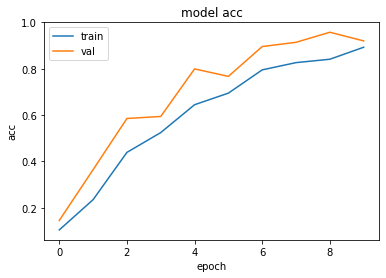

In [19]:
# PLOTTING ACCURACY

plt.plot(cnn_hist.history['acc'])
plt.plot(cnn_hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('final_acc.png', bbox_inches='tight')
plt.show()

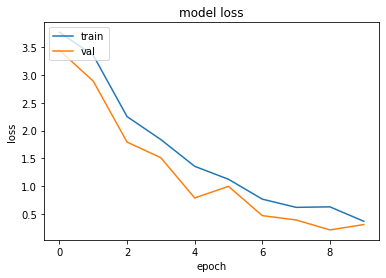

In [20]:
# PLOTTING LOSS

plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('final_loss.png', bbox_inches='tight')
plt.show()

In [21]:
# PREPARING TESTING DATA

testing_list = testing_list.astype('float32')/255.

lb = LabelEncoder()
testing_label = np_utils.to_categorical(lb.fit_transform(testing_label.ravel()))                                    

In [22]:
# EVALUATING THE MODEL

result = cnn_model.evaluate(testing_list, testing_label, verbose=0)
print ("%s: %.2f%%" % (cnn_model.metrics_names[1], result[1]*100))

acc: 38.55%


In [23]:
# SAVING THE MODEL

model_name = 'final_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
cnn_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_json = cnn_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Saved trained model at C:\Users\nazir\Desktop\CNN - FaceRecognition\saved_models\final_model.h5 


In [24]:
# PREDICTING WITHOUT LABELS AND SAVING TO .CSV FILE

preds = cnn_model.predict(testing_list, batch_size=32, verbose=1)

max_percentage_predictions = preds.argmax(axis=1)
flatten_predictions = max_percentage_predictions.astype(int).flatten()

predictions = (lb.inverse_transform((flatten_predictions)))
predictions_df = pd.DataFrame({'predictedvalues': predictions})

true_values = testing_label.argmax(axis=1)
flatten_true_values = true_values.astype(int).flatten()

true_values = (lb.inverse_transform((flatten_true_values)))
true_values_df = pd.DataFrame({'actualvalues': true_values})

predictions_and_truevalues = true_values_df.join(predictions_df)
predictions_and_truevalues.to_csv('Predictions.csv', index=False)

3593/3593 [==============================] - 117s 33ms/step
